In [1]:
# Import Modules
import xarray as xr
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
from scipy.signal import detrend
import cartopy.crs as ccrs
from matplotlib.colorbar import ColorbarBase

In [2]:
def load_data(member):
    tas_path = f"/work/uo1075/u301680/all_member/land/europe_{member}_land.nc"
    tos_path = f"/work/uo1075/u301680/all_member/ocean/member_{member}_tos_regrid.nc"

    all_tas = xr.open_dataset(tas_path)
    all_tos = xr.open_dataset(tos_path)

    return all_tas, all_tos

def subset_data(all_data, time_range, lat_range, lon_range):
    subset_data = all_data.sel(time=slice(*time_range), lat=slice(*lat_range), lon=slice(*lon_range))
    return subset_data

def calculate_seasonal_mean(data, freq, month):
    seasonal_mean = data.resample(time=freq).mean()
    return seasonal_mean.sel(time=seasonal_mean.time.dt.month == month)

def fill_and_interpolate(data, fill_value=0):
    data_filled = data.fillna(fill_value)
    data_interpolated = data_filled.interpolate_na(dim='time', method='linear')
    return data_interpolated


def detrend_data(data):
    return detrend(data, axis=0)

def area_average(data):
    return np.nanmean(data, axis=(1, 2))

def calculate_correlation(x, y):
    std_x = np.std(x)
    std_y = np.std(y)

    if std_x == 0 or std_y == 0:
        return np.nan
    else:
        return np.corrcoef(x, y)[0, 1]

### Correlation between each grid point of Autumn SST and Winter SAT values

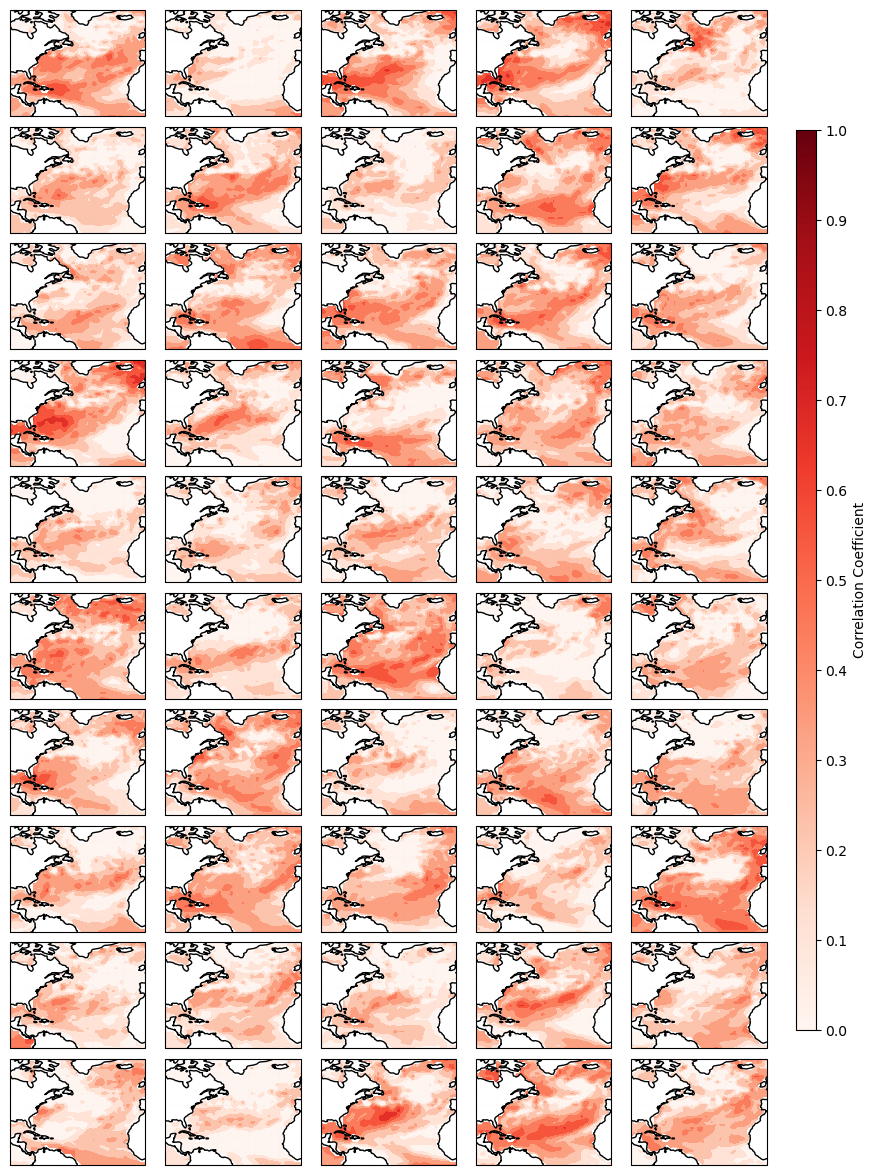

In [3]:
# Set the number of rows and columns
num_rows = 10
num_columns = 5

# Create a figure and axes for subplots with a PlateCarree projection
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Set contour levels, color, and color levels
contour_levels = np.arange(0, 1.1, 0.1)
single_color = 'darkred'
num_levels = 10 
colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

# Create a colorbar axis (cax) outside of the subplots
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust position and size as needed

# Iterate over member numbers from 1 to 50
for member in range(1, 51):
    # Load data for the current member
    all_tas, all_tos = load_data(member)
    
    tas_subset = subset_data(all_tas, time_range=("1960", "2014"), lat_range=(30, 80), lon_range=(-30, 40))
    tos_subset = subset_data(all_tos, time_range=("1960", "2014"), lat_range=(0, 70), lon_range=(265, 355))

    winter_sat = calculate_seasonal_mean(tas_subset['tas'], freq="QS-DEC", month=12)[1:]
    autumn_sst = calculate_seasonal_mean(tos_subset['tos'], freq="QS-DEC", month=9)
    
    winter_sat_values = area_average(winter_sat)
    autumn_sst_values = area_average(autumn_sst)
        
    corr_NA = np.empty((len(autumn_sst['lat']), len(autumn_sst['lon'])))

    for i, lat in enumerate(autumn_sst['lat']):
        for j, lon in enumerate(autumn_sst['lon']):
            value = autumn_sst.sel(lat=lat, lon=lon)
            correlation = calculate_correlation(winter_sat_values, value)#[0, 1]
            corr_NA[i, j] = correlation

    # Get the current subplot
    ax = axes[member - 1]
    
    # Plot the correlation values over the North Atlantic region on the current subplot
    c = ax.contourf(autumn_sst['lon'], autumn_sst['lat'], corr_NA, colors=colors, transform=ccrs.PlateCarree(), 
                    extend='both', levels=contour_levels)
    
    # Add gridlines and labels to the map
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines()
    

# Create a single colorbar for all subplots
cb = ColorbarBase(cax, cmap=plt.cm.Reds, ticks=contour_levels, label='Correlation Coefficient')
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust the values as needed

# Adjust layout and show the plots
# plt.tight_layout()
#plt.savefig("correlation one")
# plt.title("Correlation Over North Atlnatic")
plt.show()

### Correlation between each grid point of Winter SAT and Autumn SST values

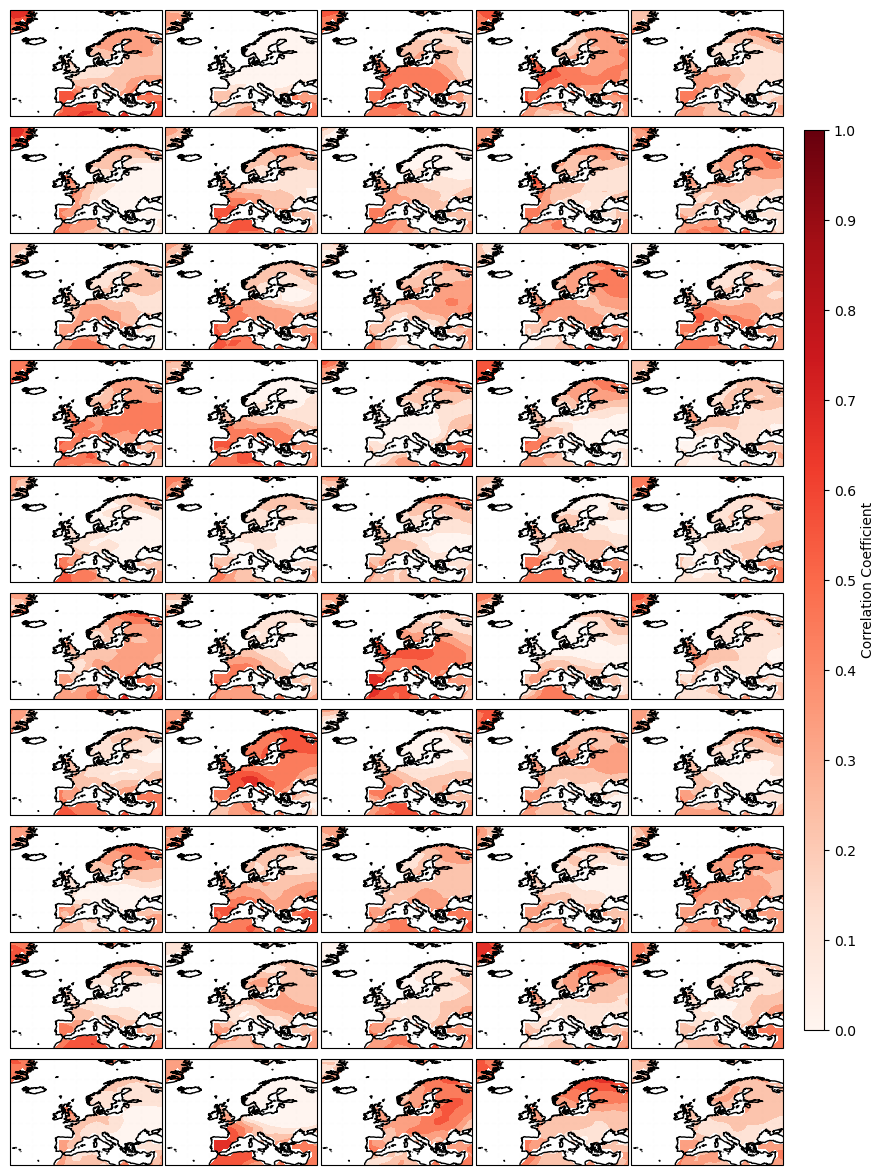

In [4]:
# Set the number of rows and columns
num_rows = 10
num_columns = 5

# Create a figure and axes for subplots with a PlateCarree projection
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Set contour levels, color, and color levels
contour_levels = np.arange(0, 1.1, 0.1)
single_color = 'darkred'
num_levels = 10 
colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

# Create a colorbar axis (cax) outside of the subplots
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust position and size as needed

# Iterate over member numbers from 1 to 50
for member in range(1, 51):
    # Load data for the current member
    all_tas, all_tos = load_data(member)
    
    tas_subset = subset_data(all_tas, time_range=("1960", "2014"), lat_range=(30, 80), lon_range=(-30, 40))
    tos_subset = subset_data(all_tos, time_range=("1960", "2014"), lat_range=(0, 70), lon_range=(265, 355))

    winter_sat = calculate_seasonal_mean(tas_subset['tas'], freq="QS-DEC", month=12)[1:]
    autumn_sst = calculate_seasonal_mean(tos_subset['tos'], freq="QS-DEC", month=9)
    
    winter_sat_values = area_average(winter_sat)
    autumn_sst_values = area_average(autumn_sst)
    
    corr_EU = np.empty((len(winter_sat['lat']), len(winter_sat['lon'])))

    for i, lat in enumerate(winter_sat['lat']):
        for j, lon in enumerate(winter_sat['lon']):
            value = winter_sat.sel(lat=lat, lon=lon)
            correlation = calculate_correlation(autumn_sst_values, value)#[0, 1]
            corr_EU[i, j] = correlation
            
    # Get the current subplot
    ax = axes[member - 1]

    # Plot the correlation values over the North Atlantic region on the current subplot
    c = ax.contourf(winter_sat['lon'], winter_sat['lat'], corr_EU, colors=colors, transform=ccrs.PlateCarree(), 
                    extend='both', levels=contour_levels) 

    # Add gridlines and labels to the map
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines()
    
# Create a single colorbar for all subplots
cb = ColorbarBase(cax, cmap=plt.cm.Reds, ticks=contour_levels, label='Correlation Coefficient')
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust the values as needed

# Adjust layout and show the plots
# plt.tight_layout()
# plt.savefig("correlation two")
# plt.title("Correlation Over North Atlnatic")
plt.show()

### Correlation above threshold (0.3) each grid cell of Autumn SST and Winter SAT values

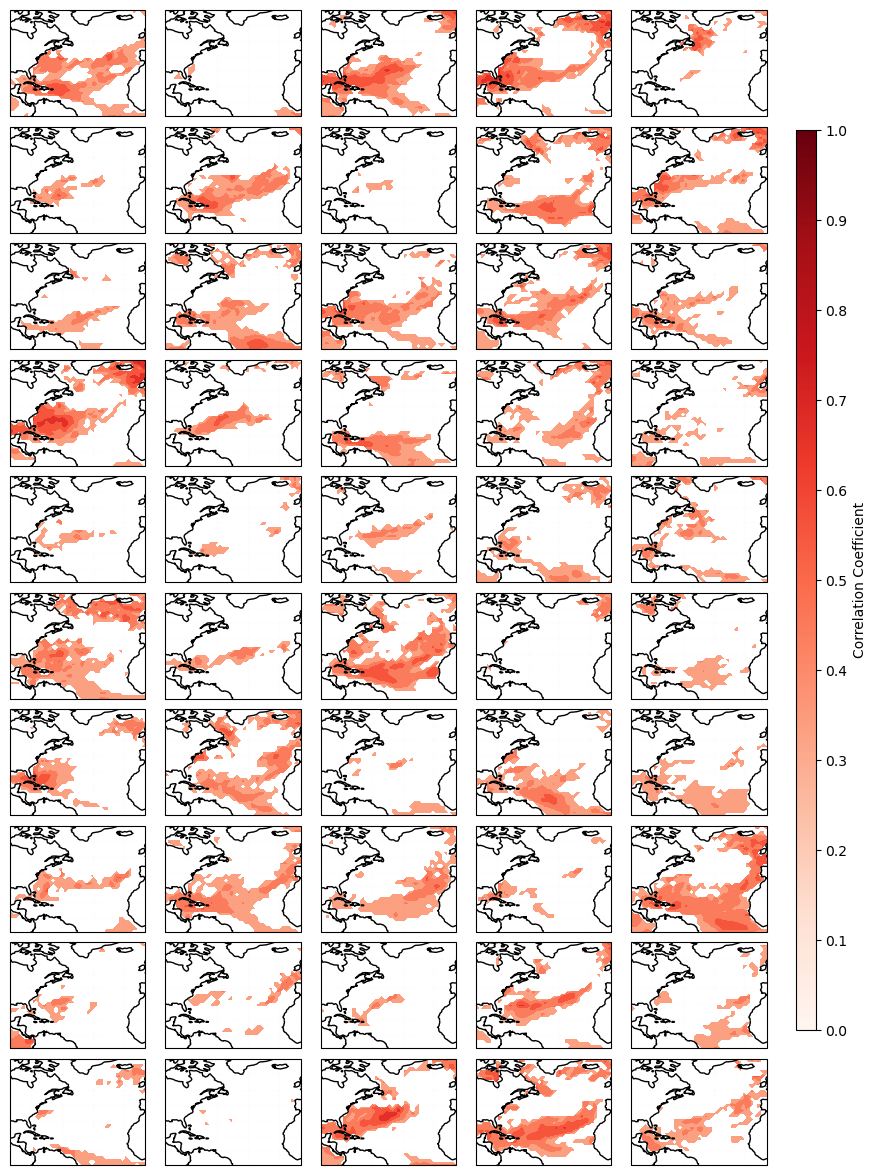

In [5]:
# Set the number of rows and columns
num_rows = 10
num_columns = 5

# Create a figure and axes for subplots with a PlateCarree projection
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Set contour levels, color, and color levels
contour_levels = np.arange(0, 1.1, 0.1)
single_color = 'darkred'
num_levels = 10 
colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

# Create a colorbar axis (cax) outside of the subplots
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust position and size as needed

# Iterate over member numbers from 1 to 50
for member in range(1, 51):
    # Load data for the current member
    all_tas, all_tos = load_data(member)
    
    tas_subset = subset_data(all_tas, time_range=("1960", "2014"), lat_range=(30, 80), lon_range=(-30, 40))
    tos_subset = subset_data(all_tos, time_range=("1960", "2014"), lat_range=(0, 70), lon_range=(265, 355))

    winter_sat = calculate_seasonal_mean(tas_subset['tas'], freq="QS-DEC", month=12)[1:]
    autumn_sst = calculate_seasonal_mean(tos_subset['tos'], freq="QS-DEC", month=9)
    
    winter_sat_values = area_average(winter_sat)
    autumn_sst_values = area_average(autumn_sst)
    
    corr_NA = np.empty((len(autumn_sst['lat']), len(autumn_sst['lon'])))

    for i, lat in enumerate(autumn_sst['lat']):
        for j, lon in enumerate(autumn_sst['lon']):
            value = autumn_sst.sel(lat=lat, lon=lon)
            correlation = calculate_correlation(winter_sat_values, value) #[0, 1]
            corr_NA[i, j] = correlation
            
    # Select regions with correlation above 0.3
    threshold = 0.3
    above_threshold_mask = corr_NA > threshold
    
    # Get the current subplot
    ax = axes[member - 1]

    # Plot the correlation values over the North Atlantic region on the current subplot
    c = ax.contourf(autumn_sst['lon'], autumn_sst['lat'], np.ma.masked_where(~above_threshold_mask, corr_NA), colors=colors, 
                    transform=ccrs.PlateCarree(), extend='both', levels=contour_levels)

    # Add gridlines and labels to the map
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines()
    
    
# Create a single colorbar for all subplots
cb = ColorbarBase(cax, cmap=plt.cm.Reds, ticks=contour_levels, label='Correlation Coefficient')
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust the values as needed

# Adjust layout and show the plots
# plt.tight_layout()
# plt.savefig("correlation three")
# plt.title("Correlation Over North Atlnatic")
plt.show()

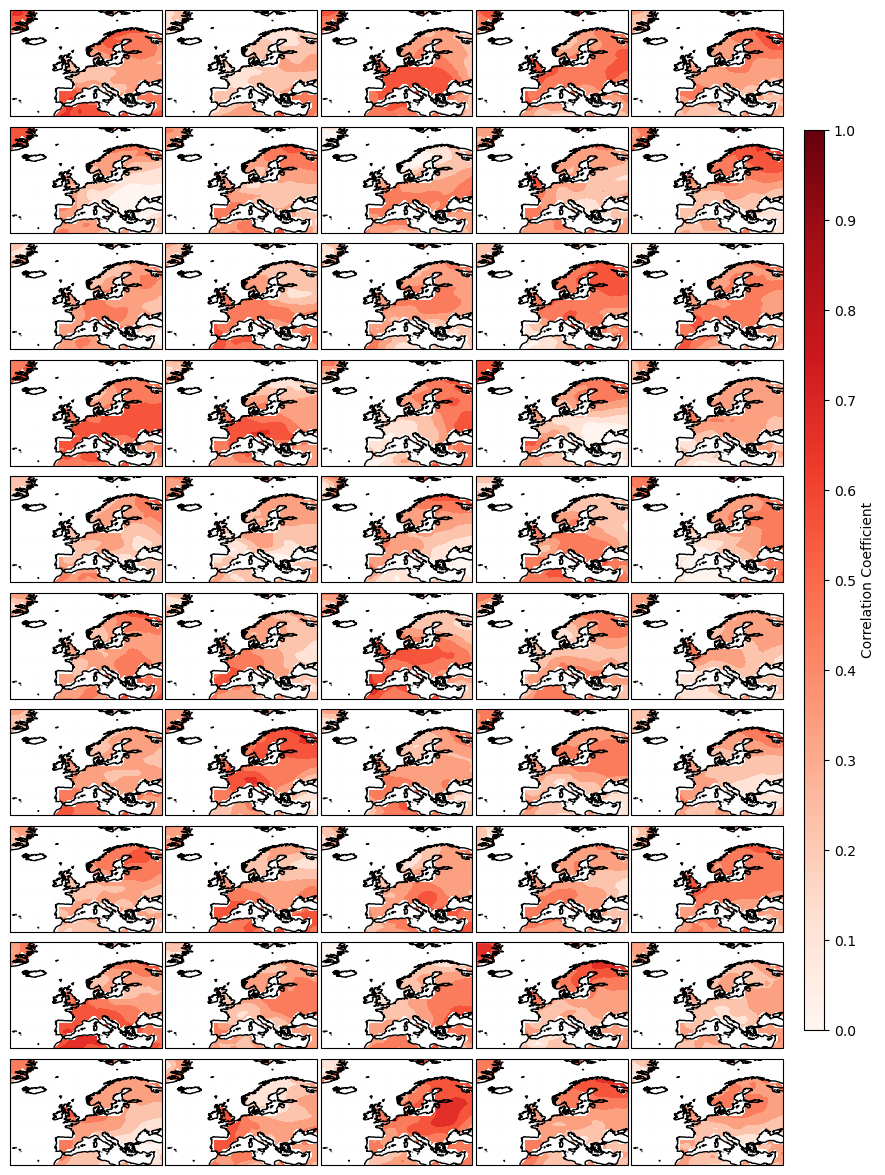

In [6]:
# Set the number of rows and columns
num_rows = 10
num_columns = 5

# Create a figure and axes for subplots with a PlateCarree projection
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Set contour levels, color, and color levels
contour_levels = np.arange(0, 1.1, 0.1)
single_color = 'darkred'
num_levels = 10 
colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

# Create a colorbar axis (cax) outside of the subplots
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust position and size as needed

# Iterate over member numbers from 1 to 50
for member in range(1, 51):
    # Load data for the current member
    all_tas, all_tos = load_data(member)
    
    tas_subset = subset_data(all_tas, time_range=("1960", "2014"), lat_range=(30, 80), lon_range=(-30, 40))
    tos_subset = subset_data(all_tos, time_range=("1960", "2014"), lat_range=(0, 70), lon_range=(265, 355))

    winter_sat = calculate_seasonal_mean(tas_subset['tas'], freq="QS-DEC", month=12)[1:]
    autumn_sst = calculate_seasonal_mean(tos_subset['tos'], freq="QS-DEC", month=9)
    
    winter_sat_values = area_average(winter_sat)
    autumn_sst_values = area_average(autumn_sst)
    
    corr_NA = np.empty((len(autumn_sst['lat']), len(autumn_sst['lon'])))

    for i, lat in enumerate(autumn_sst['lat']):
        for j, lon in enumerate(autumn_sst['lon']):
            value = autumn_sst.sel(lat=lat, lon=lon)
            correlation = calculate_correlation(winter_sat_values, value) #[0, 1]
            corr_NA[i, j] = correlation
            
    threshold = 0.3
    above_threshold_mask = corr_NA > threshold
    
    autumn_sst_above_threshold = autumn_sst.where(above_threshold_mask)
    autumn_sst_valuesabove_threshold = np.nanmean(autumn_sst_above_threshold, axis=(1, 2))
    
    corr_EU_above_threshold = np.empty((len(winter_sat['lat']), len(winter_sat['lon'])))

    for i, lat in enumerate(winter_sat['lat']):
        for j, lon in enumerate(winter_sat['lon']):
            value = winter_sat.sel(lat=lat, lon=lon)
            correlation = calculate_correlation(autumn_sst_valuesabove_threshold, value)#[0, 1]
            corr_EU_above_threshold[i, j] = correlation
            
    # Get the current subplot
    ax = axes[member - 1]

    # Plot the correlation values over the North Atlantic region on the current subplot
    c = ax.contourf(winter_sat['lon'], winter_sat['lat'], corr_EU_above_threshold, colors=colors, transform=ccrs.PlateCarree(), 
                    extend='both', levels=contour_levels)

    # Add gridlines and labels to the map
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines()
    
# Create a single colorbar for all subplots
cb = ColorbarBase(cax, cmap=plt.cm.Reds, ticks=contour_levels, label='Correlation Coefficient')
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust the values as needed

# Adjust layout and show the plots
# plt.tight_layout()
plt.savefig("correlation four")
# plt.title("Correlation Over North Atlnatic")
plt.show()  

### Detended Correlation 

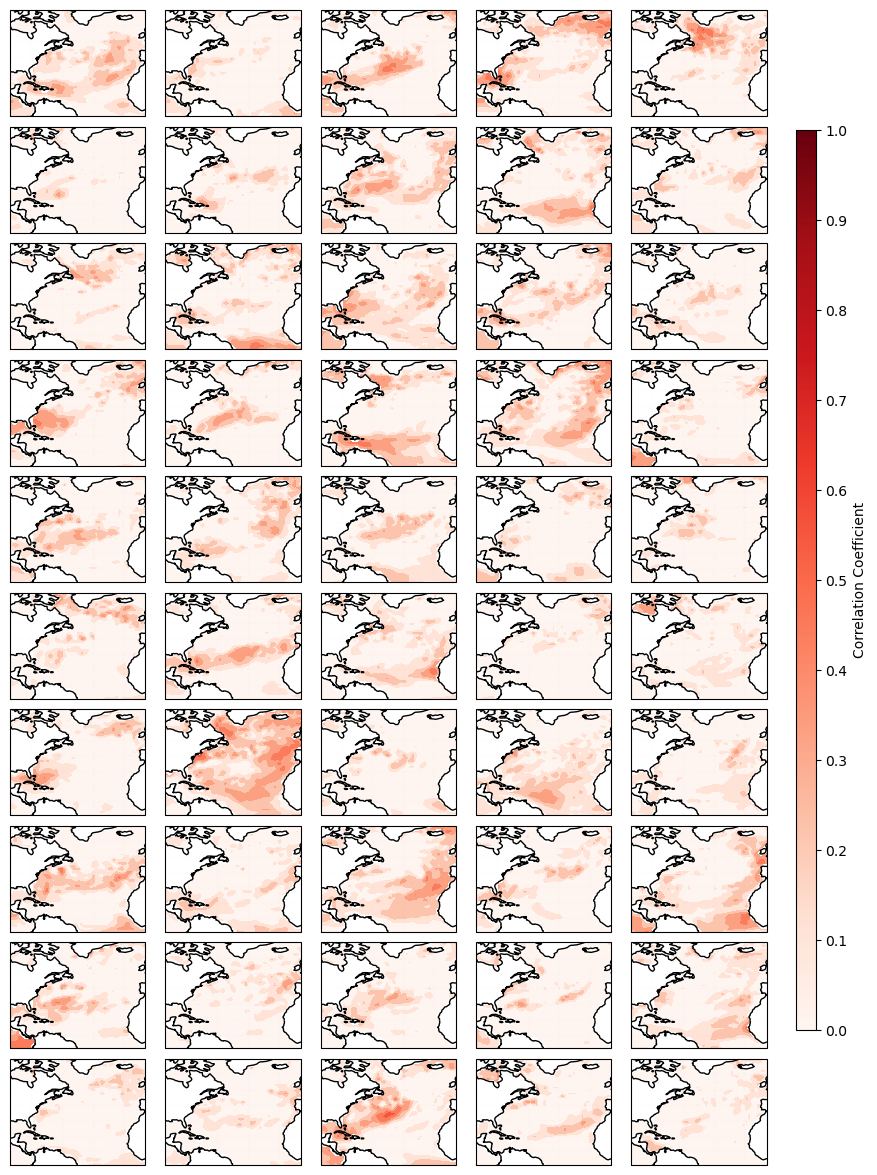

In [7]:
# Set the number of rows and columns
num_rows = 10
num_columns = 5

# Create a figure and axes for subplots with a PlateCarree projection
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Set contour levels, color, and color levels
contour_levels = np.arange(0, 1.1, 0.1)
single_color = 'darkred'
num_levels = 10 
colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

# Create a colorbar axis (cax) outside of the subplots
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust position and size as needed

# Iterate over member numbers from 1 to 50
for member in range(1, 51):
    # Load data for the current member
    all_tas, all_tos = load_data(member)
    
    tas_subset = subset_data(all_tas, time_range=("1960", "2014"), lat_range=(30, 80), lon_range=(-30, 40))
    tos_subset = subset_data(all_tos, time_range=("1960", "2014"), lat_range=(0, 70), lon_range=(265, 355))

    winter_sat = calculate_seasonal_mean(tas_subset['tas'], freq="QS-DEC", month=12)[1:]
    autumn_sst = calculate_seasonal_mean(tos_subset['tos'], freq="QS-DEC", month=9)

    winter_sat_detrended = detrend_data(fill_and_interpolate(winter_sat))
    autumn_sst_detrended = detrend_data(fill_and_interpolate(autumn_sst))
    
    winter_sat_values = area_average(winter_sat_detrended)
    autumn_sst_values = area_average(autumn_sst_detrended)

    corr_detrended = np.empty((len(autumn_sst['lat']), len(autumn_sst['lon'])))

    for i, lat in enumerate(autumn_sst['lat']):
        for j, lon in enumerate(autumn_sst['lon']):
            value = autumn_sst_detrended[:, i, j]
            correlation = calculate_correlation(winter_sat_values, value)
            corr_detrended[i, j] = correlation

    # Get the current subplot
    ax = axes[member - 1]

    # Plot the correlation values over the North Atlantic region on the current subplot
    c = ax.contourf(autumn_sst['lon'], autumn_sst['lat'], corr_detrended, colors=colors, transform=ccrs.PlateCarree(), 
                    extend='both', levels=contour_levels)

    # Add gridlines and labels to the map
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines()

# Create a single colorbar for all subplots
cb = ColorbarBase(cax, cmap=plt.cm.Reds, ticks=contour_levels, label='Correlation Coefficient')
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust the values as needed

# Adjust layout and show the plots
# plt.tight_layout()
plt.savefig("correlation five")
# plt.title("Correlation Over North Atlnatic")
plt.show()

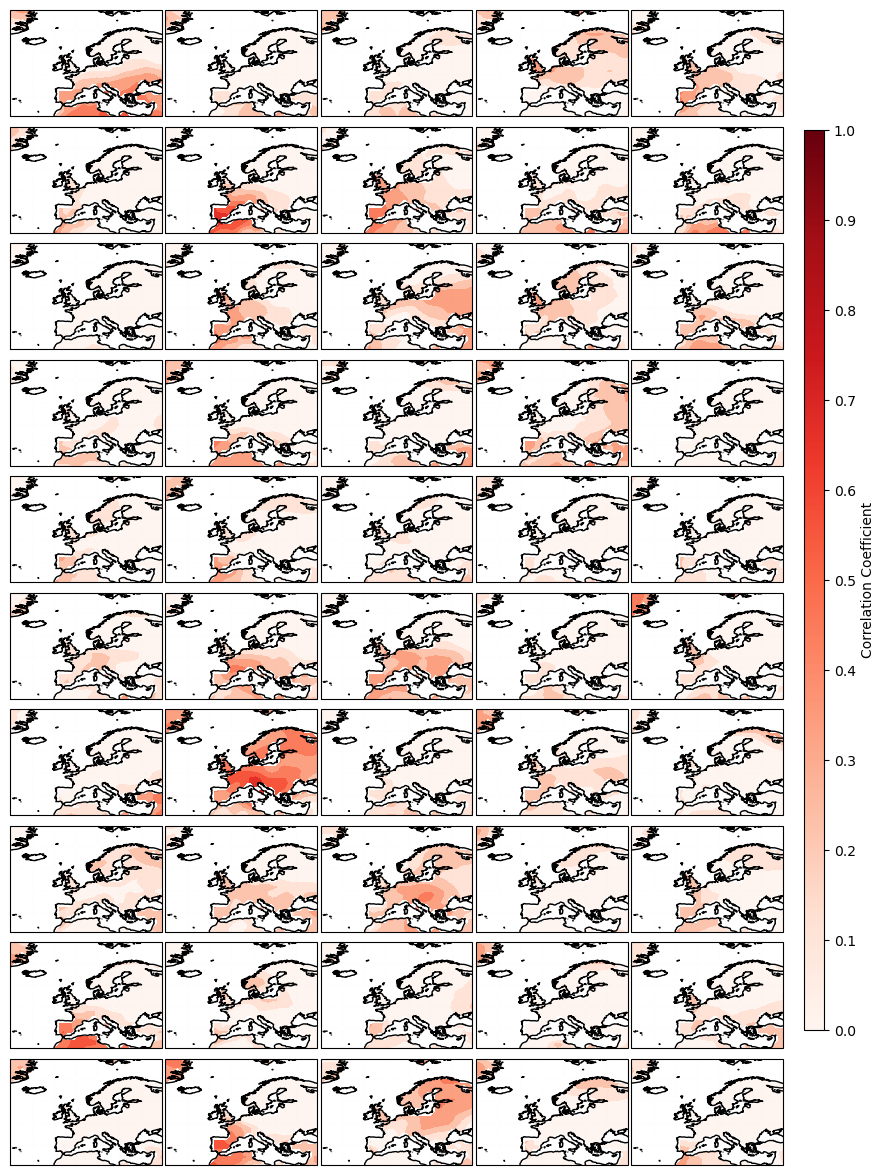

In [8]:
# Set the number of rows and columns
num_rows = 10
num_columns = 5

# Create a figure and axes for subplots with a PlateCarree projection
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Set contour levels, color, and color levels
contour_levels = np.arange(0, 1.1, 0.1)
single_color = 'darkred'
num_levels = 10 
colors = [plt.cm.Reds(i / (num_levels - 1)) for i in range(num_levels)]

# Create a colorbar axis (cax) outside of the subplots
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust position and size as needed

# Iterate over member numbers from 1 to 50
for member in range(1, 51):
    # Load data for the current member
    all_tas, all_tos = load_data(member)
    
    tas_subset = subset_data(all_tas, time_range=("1960", "2014"), lat_range=(30, 80), lon_range=(-30, 40))
    tos_subset = subset_data(all_tos, time_range=("1960", "2014"), lat_range=(0, 70), lon_range=(265, 355))

    winter_sat = calculate_seasonal_mean(tas_subset['tas'], freq="QS-DEC", month=12)[1:]
    autumn_sst = calculate_seasonal_mean(tos_subset['tos'], freq="QS-DEC", month=9)

    winter_sat_detrended = detrend_data(fill_and_interpolate(winter_sat))
    autumn_sst_detrended = detrend_data(fill_and_interpolate(autumn_sst))
    
    winter_sat_values = area_average(winter_sat_detrended)
    autumn_sst_values = area_average(autumn_sst_detrended)

    corr_detrended = np.empty((len(winter_sat['lat']), len(winter_sat['lon'])))

    for i, lat in enumerate(winter_sat['lat']):
        for j, lon in enumerate(winter_sat['lon']):
            value = winter_sat_detrended[:, i, j]
            correlation = calculate_correlation(autumn_sst_values, value)
            corr_detrended[i, j] = correlation

    # Get the current subplot
    ax = axes[member - 1]

    # Plot the correlation values over the North Atlantic region on the current subplot
    c = ax.contourf(winter_sat['lon'], winter_sat['lat'], corr_detrended, colors=colors, transform=ccrs.PlateCarree(), 
                    extend='both', levels=contour_levels)

    # Add gridlines and labels to the map
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines()

# Create a single colorbar for all subplots
cb = ColorbarBase(cax, cmap=plt.cm.Reds, ticks=contour_levels, label='Correlation Coefficient')
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjust the values as needed

# Adjust layout and show the plots
# plt.tight_layout()
plt.savefig("correlation six")
# plt.title("Correlation Over North Atlnatic")
plt.show()